In [3]:
import pandas as pd
import numpy as np

In [6]:
#import the backtesting dataset
pfe = pd.read_csv('I:\python_file\save\M4 (1)\LSTM Multi\LSTM_raw_sent.csv', index_col=0)
pfe = pfe.set_index(pd.DatetimeIndex(pfe.index))

In [18]:
pfe

,Adj Close,Daily Return,neg,neu,pos,Predict_close
Date,,,,,,
2021-06-02,38.107330,0.007533,0.075364,0.859182,0.065455,0.002848
2021-06-03,38.284161,0.004640,0.068143,0.833429,0.098429,0.002819
2021-06-04,38.460995,0.004619,0.053667,0.840000,0.106222,0.002788
2021-06-07,38.303810,-0.004087,0.046333,0.863000,0.090750,0.002834
2021-06-08,38.166271,-0.003591,0.071600,0.881600,0.046800,0.002842
...,...,...,...,...,...,...
2021-12-08,51.400002,-0.006187,0.057240,0.871200,0.071560,0.001181
2021-12-09,52.080002,0.013230,0.010294,0.931176,0.058529,0.000763
2021-12-10,52.779999,0.013441,0.049933,0.785667,0.164333,0.000791


In [8]:
#import the dataset into a new dataframe 
signals = pd.DataFrame(index=pfe.index)
signals['signal'] = 0.0
#signals['return'] = pfe['Daily Return']
signals['predict'] = pfe['Predict_close']
signals['close'] = pfe['Adj Close']
signals['date'] = signals.index
signals = signals.reset_index()

In [9]:
#Create signals when to buy the stock dependet on the predctions 

# how big should the prediction be before buy position 
#span = 0.0005
span = 0.001
#Create signal if the stock is going up by more then the span
predict_list = [0]
for x in signals['predict']:     
    if x > span:
        list = 1
        predict_list.append(list)
    elif predict_list[-1]==1:
        if x<-0.001:
            list1 = 1
            predict_list.append(list1)
        #else:
        #    list2 = -1
        #    predict_list.append(list2)
        else: 
            list3 = 0
            predict_list.append(list3)
    else: 
        list3 = 0
        predict_list.append(list3)

del predict_list[0]
#del predict_list[-1]
#predict_list.append(-1)
signals['signal'] = predict_list

In [10]:
# create a new list depending on the signal 
#buy and keep aslong as the signal says 1 and change to sell -1 when the buy signal stops 
signals['positions'] = signals['signal'].diff()

#import the dates as index again
signals = signals.set_index('Date',drop=True)
#<del signals['index']

In [11]:
signals.head(5)

,signal,predict,close,date,positions
Date,,,,,
2021-04-08,1,0.003861,34.982433,2021-04-08,NaN
2021-04-09,1,0.003785,35.605034,2021-04-09,0.0
2021-04-12,1,0.004058,35.964977,2021-04-12,0.0
2021-04-13,1,0.004271,36.149815,2021-04-13,0.0
2021-04-14,1,0.004541,36.159538,2021-04-14,0.0


In [12]:
mask = (signals.index > '2021-6-1')
signals = signals.loc[mask]

In [13]:
print(signals.signal.value_counts())
print(signals.positions.value_counts())

1    118
0     19
Name: signal, dtype: int64
 0.0    129
-1.0      4
 1.0      4
Name: positions, dtype: int64


In [14]:
pfe = pfe.loc[mask]

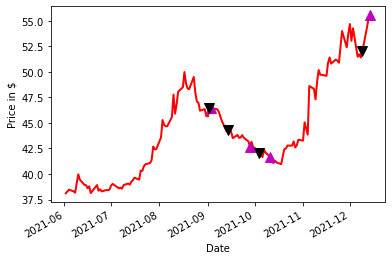

In [15]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
pfe['Adj Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
#signals[['short_mavg_return', 'short_mavg_predict']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.close[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.close[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [16]:
# Set the initial capital
initial_capital= float(1000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['PFE'] = 10*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(pfe['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(pfe['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(pfe['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

                   PFE    holdings         cash        total   returns
Date                                                                  
2021-12-08  514.000015  514.000015  1020.123329  1534.123344 -0.002082
2021-12-09    0.000000    0.000000  1540.923347  1540.923347  0.004433
2021-12-10    0.000000    0.000000  1540.923347  1540.923347  0.000000
2021-12-13    0.000000    0.000000  1540.923347  1540.923347  0.000000
2021-12-14  555.400009  555.400009   985.523338  1540.923347  0.000000


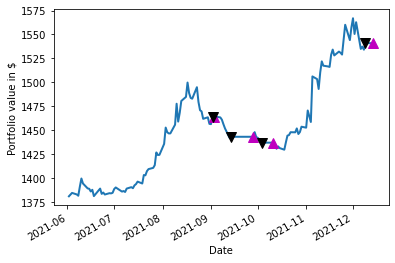

In [17]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>